**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file

from stardist import relabel_image_stardist3D, Rays_GoldenSpiral, calculate_extents
from stardist import fill_label_holes, random_label_cmap
from stardist.matching import matching_dataset

np.random.seed(42)
lbl_cmap = random_label_cmap()

/tmp/ipykernel_2306897/204291089.py:4: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams["image.interpolation"] = None


# Data

This notebook demonstrates how the training data for *StarDist* should look like and whether the annotated objects can be appropriately described by star-convex polyhedra. 

<div class="alert alert-block alert-info">
The training data that needs to be provided for StarDist consists of corresponding pairs of raw images and pixelwise annotated ground truth images (masks), where every pixel has a unique integer value indicating the object id (or 0 for background). 
</div>

For this demo we will download the file file `demo3D.zip` that contains synthetic train and test images with associated ground truth labels.

In [2]:
# download_and_extract_zip_file(
#     url       = 'https://github.com/stardist/stardist/releases/download/0.3.0/demo3D.zip',
#     targetdir = 'data',
#     verbose   = 1,
# )

In [3]:
import nibabel
from skimage import io as ski_io
import os
import shutil
from PIL import Image
import math
from skimage.transform import resize
from tqdm import tqdm
def check_folder(file_folder, overwrite=False):
    if "." in os.path.basename(file_folder):
        file_folder = os.path.dirname(file_folder)
    if os.path.isdir(file_folder) and overwrite:
        shutil.rmtree(file_folder)
    elif not os.path.isdir(file_folder):
        os.makedirs(file_folder)

def save_indexed_tif(file_name, data):
    """Save matrix data as indexed images which can be rendered by ImageJ"""
    # label_
    check_folder(file_name)
    # name,tp=os.path.basename(file_name).split('.')[0].split('_')[:2]
    
    embryo_name=os.path.basename(file_name).split('.')[0].split('_')[0]
    num_slices = data.shape[-1]


    tif_imgs = []
    for i_slice in range(num_slices):
        label_map = data[..., i_slice]  # avoid 256 become 0
#         label_map_out = np.squeeze((label_map + 1).astype(np.uint8))
#         label_map_out[label_map == 0] = 0
        tif_img = Image.fromarray(label_map.astype(np.uint8))
#         tif_img = Image.fromarray(label_map.astype(np.int16))

    
#         tif_img.putpalette(P)
        tif_imgs.append(tif_img)
    tif_saving=file_name.split('.')[0]+'.tif'
    if os.path.isfile(tif_saving):
        os.remove(tif_saving)
    # save the 1th slice image, treat others slices as appending
    tif_imgs[0].save(tif_saving, save_all=True, append_images=tif_imgs[1:])
    return


In [4]:
from skimage.transform import resize
def nifti2tiff(root, target, segmented):
    nifti_file_paths = glob(os.path.join(root, '*.nii.gz'))
    obj_selection_index_list = []

    #saving_obj_selection_index_list = os.path.join(os.path.dirname(target), "{}_render_indexed.txt".format(
        #os.path.basename(target).split('.')[0]))
    #print(saving_obj_selection_index_list)
    for nifti_file_path in nifti_file_paths:
#         nifti_file_arr = resize(nibabel.load(nifti_file_path).get_fdata(),(512,512,136))
        nifti_file_arr = nibabel.load(nifti_file_path).get_fdata()
        # print(np.unique(nifti_file_arr,return_counts=True))
        # target_shape = [int(x / 2) for x in nifti_file_arr.shape]
        # nifti_file_arr = resize(image=nifti_file_arr, output_shape=target_shape, preserve_range=True, order=0).astype(np.uint8)

#         if segmented is False and np.max(nifti_file_arr) < 255:
#             nifti_file_arr = (nifti_file_arr * 255 / np.max(nifti_file_arr)).astype(np.uint)
        save_file_path = os.path.join(target, os.path.basename(nifti_file_path).split(".")[0] + ".tif")
        #print('write:', save_file_path)
        save_indexed_tif(save_file_path, nifti_file_arr)

In [5]:
input_root =r'/home/home/ProjectCode/stardist/data/DuzhuoImageNiigz/images/'
output_root =r'/home/home/ProjectCode/stardist/data/DuzhuoImageTraining/images/'


nifti2tiff(input_root,output_root,False)


In [6]:
input_root =r'/home/home/ProjectCode/stardist/data/DuzhuoImageNiigz/masks/'
output_root =r'/home/home/ProjectCode/stardist/data/DuzhuoImageTraining/masks/'


nifti2tiff(input_root,output_root,True)

In [8]:
X = sorted(glob('/home/home/ProjectCode/stardist/data/DuzhuoImageTraining/images/*.tif'))
Y = sorted(glob('/home/home/ProjectCode/stardist/data/DuzhuoImageTraining/masks/*.tif'))

#assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

Load only a small subset.

In [9]:
X, Y = X[:10], Y[:10]

In [10]:
X = list(map(imread,X))
Y = list(map(imread,Y))
print(X[0].shape)
print(np.unique(Y[0],return_counts=True))

(136, 300, 184)
(array([  0,   2,  31,  61, 112], dtype=uint8), array([7490524,    4169,    4169,    4169,    4169]))


In [11]:
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (1.0, 1.0, 1.0)


# Example image

In [12]:
i = 9
img, lbl = X[i], fill_label_holes(Y[i])
assert img.ndim in (3,4)
# assumed axes ordering of img and lbl is: ZYX(C)

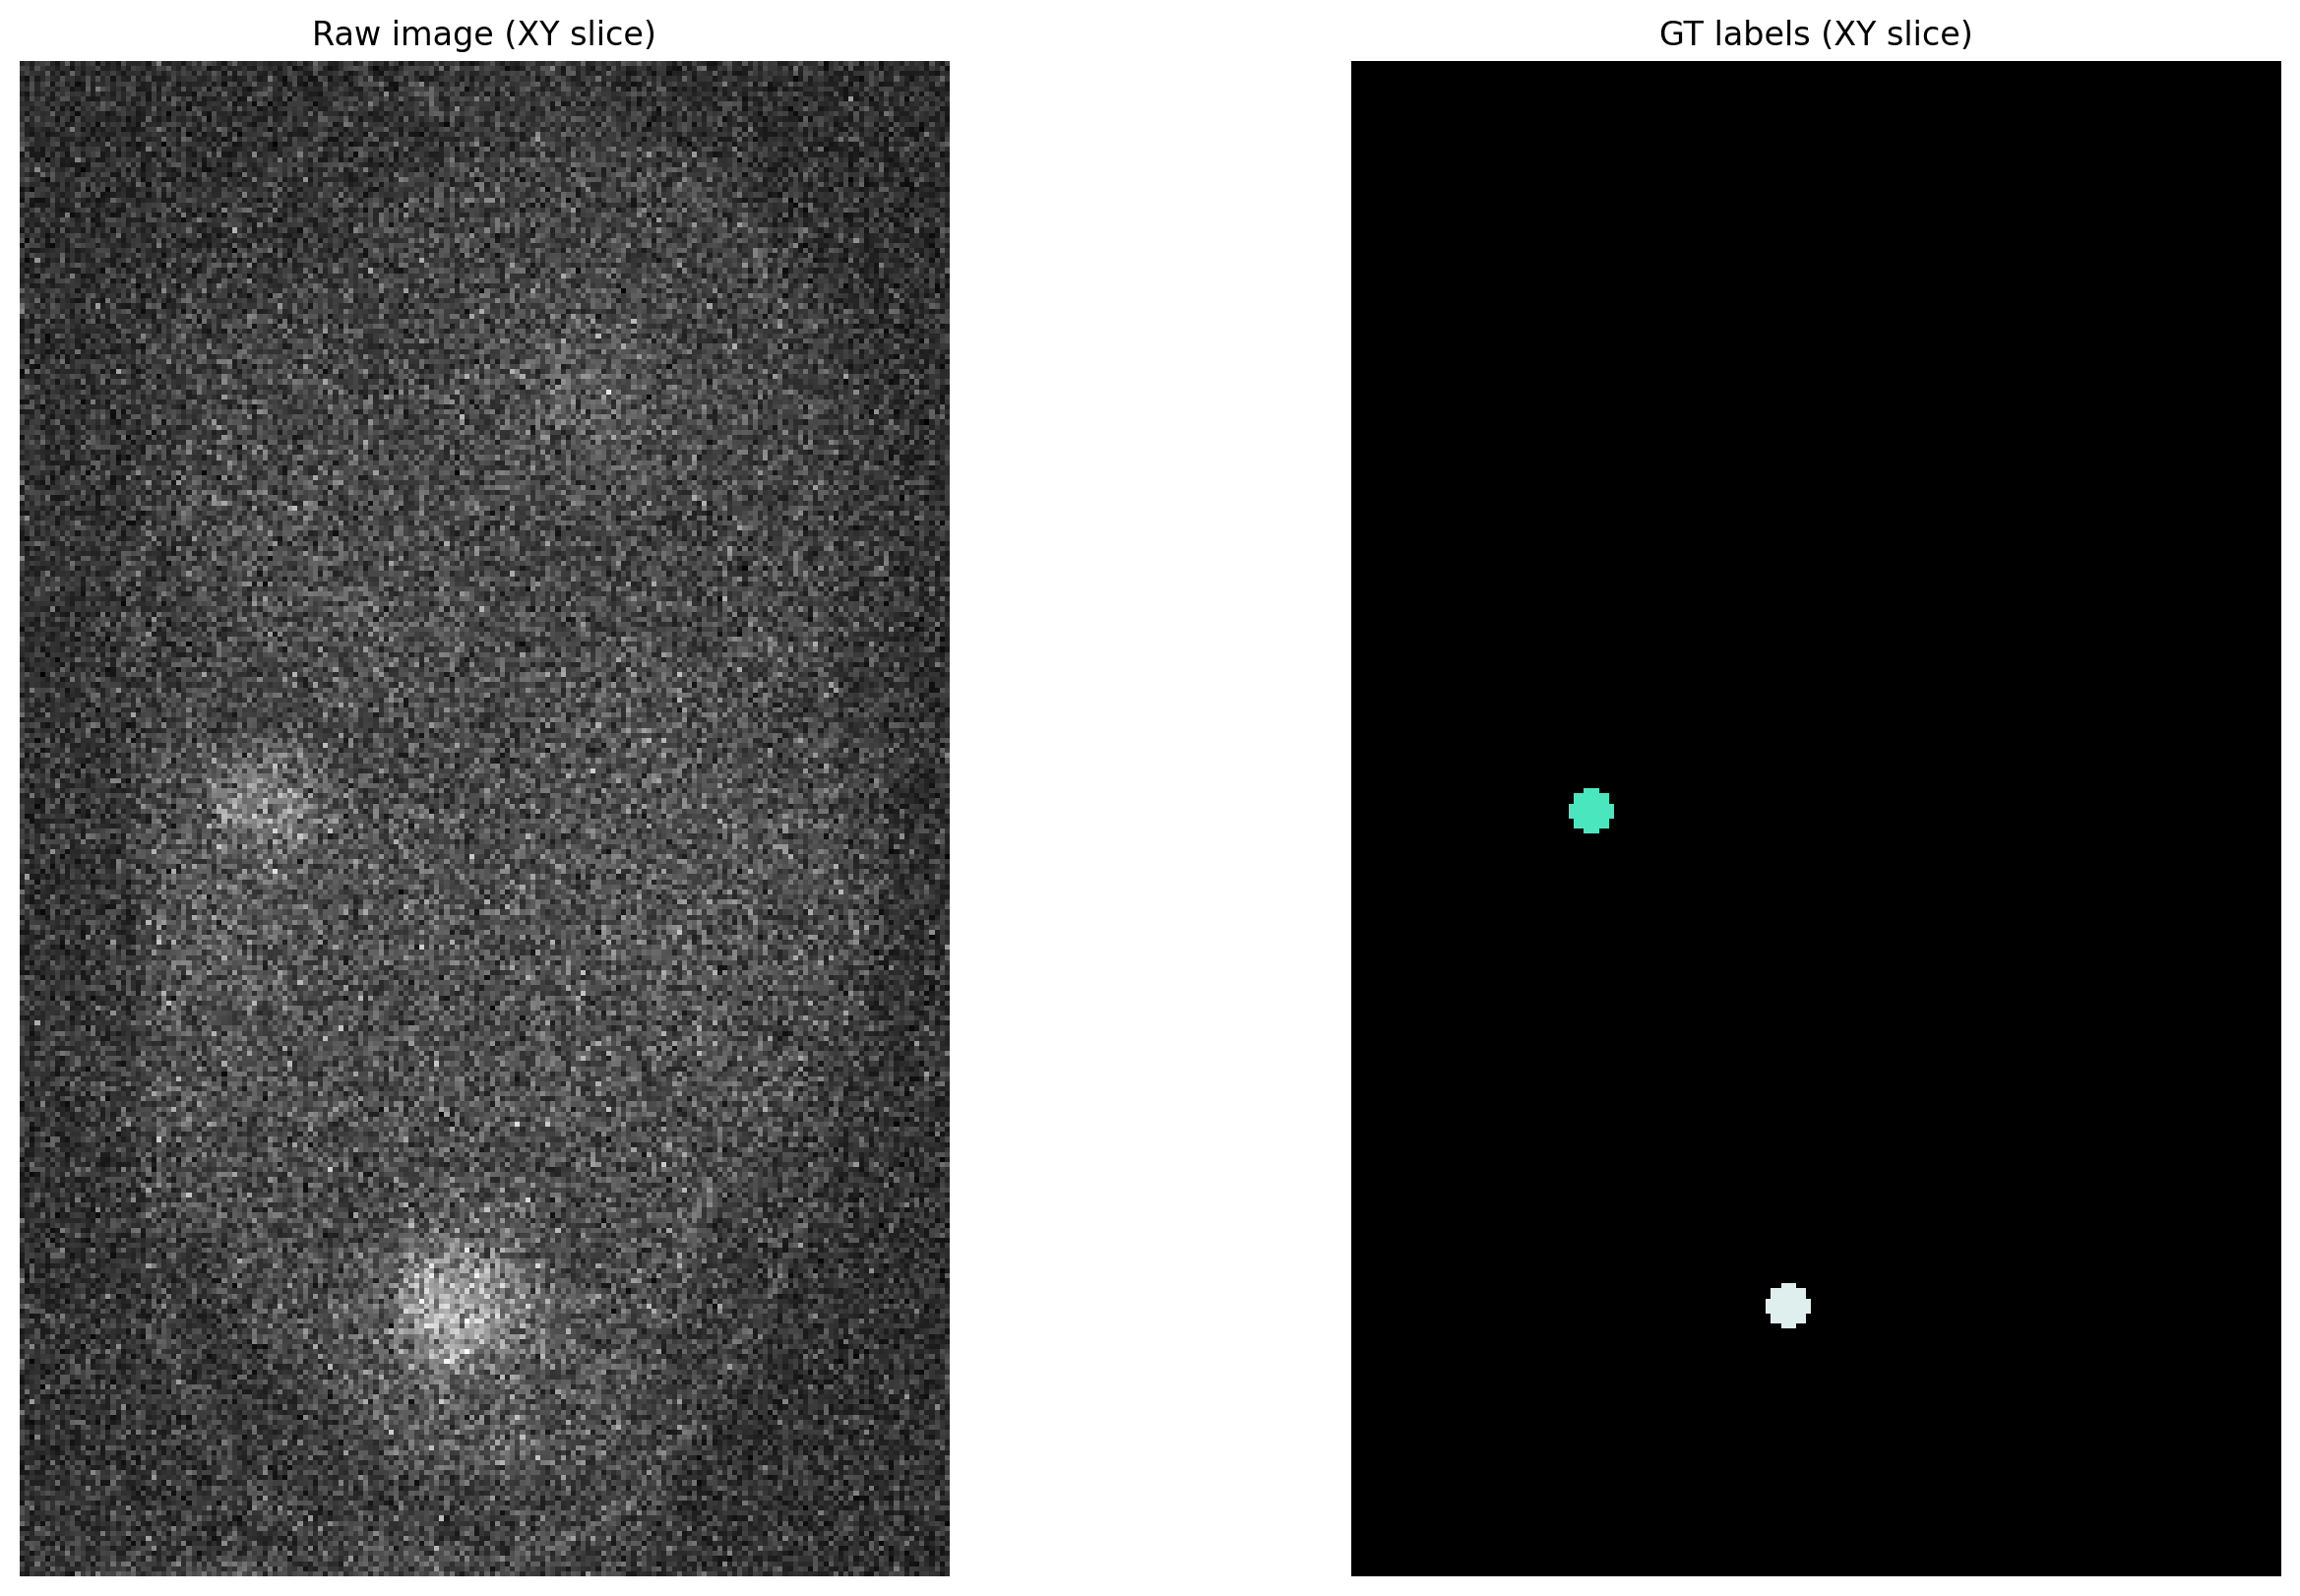

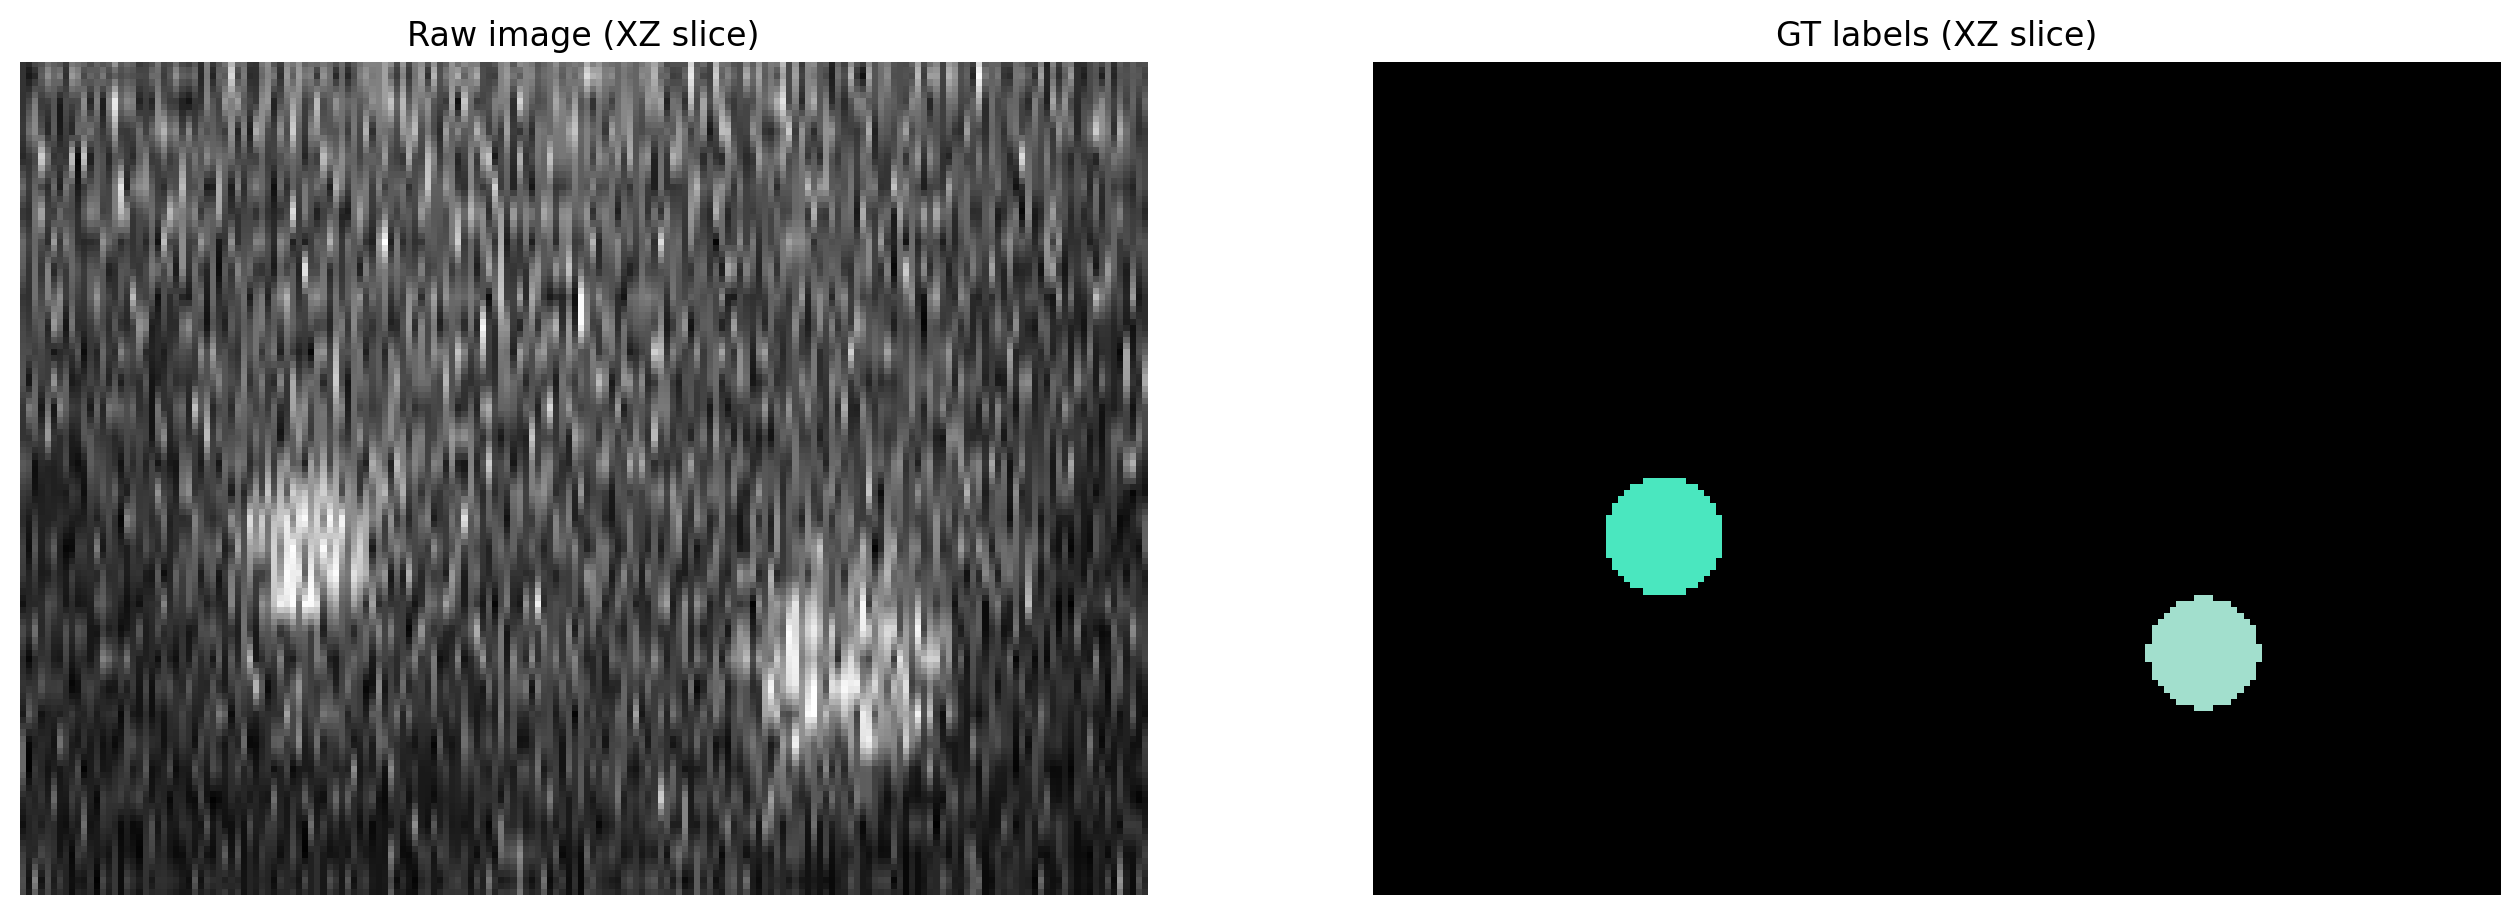

In [13]:
plt.figure(figsize=(16,10))
z = img.shape[0] // 2
y = img.shape[1] // 2
plt.subplot(121); plt.imshow(img[z],cmap='gray');   plt.axis('off'); plt.title('Raw image (XY slice)')
plt.subplot(122); plt.imshow(lbl[z],cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels (XY slice)')
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img[:,y],cmap='gray');   plt.axis('off'); plt.title('Raw image (XZ slice)')
plt.subplot(122); plt.imshow(lbl[:,y],cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels (XZ slice)')
None;

# Fitting ground-truth labels with star-convex polyhedra

In [14]:
def reconstruction_scores(n_rays, anisotropy):
    scores = []
    for r in tqdm(n_rays):
        rays = Rays_GoldenSpiral(r, anisotropy=anisotropy)
        Y_reconstructed = [relabel_image_stardist3D(lbl, rays) for lbl in Y]
        mean_iou = matching_dataset(Y, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
        scores.append(mean_iou)
    return scores

In [15]:
n_rays = [8, 16, 32, 64, 96, 128]
scores_iso   = reconstruction_scores(n_rays, anisotropy=None)
scores_aniso = reconstruction_scores(n_rays, anisotropy=anisotropy)

100%|█████████████████████████████████████████████████████████████████████████████| 6/6 [00:25<00:00,  4.17s/it]


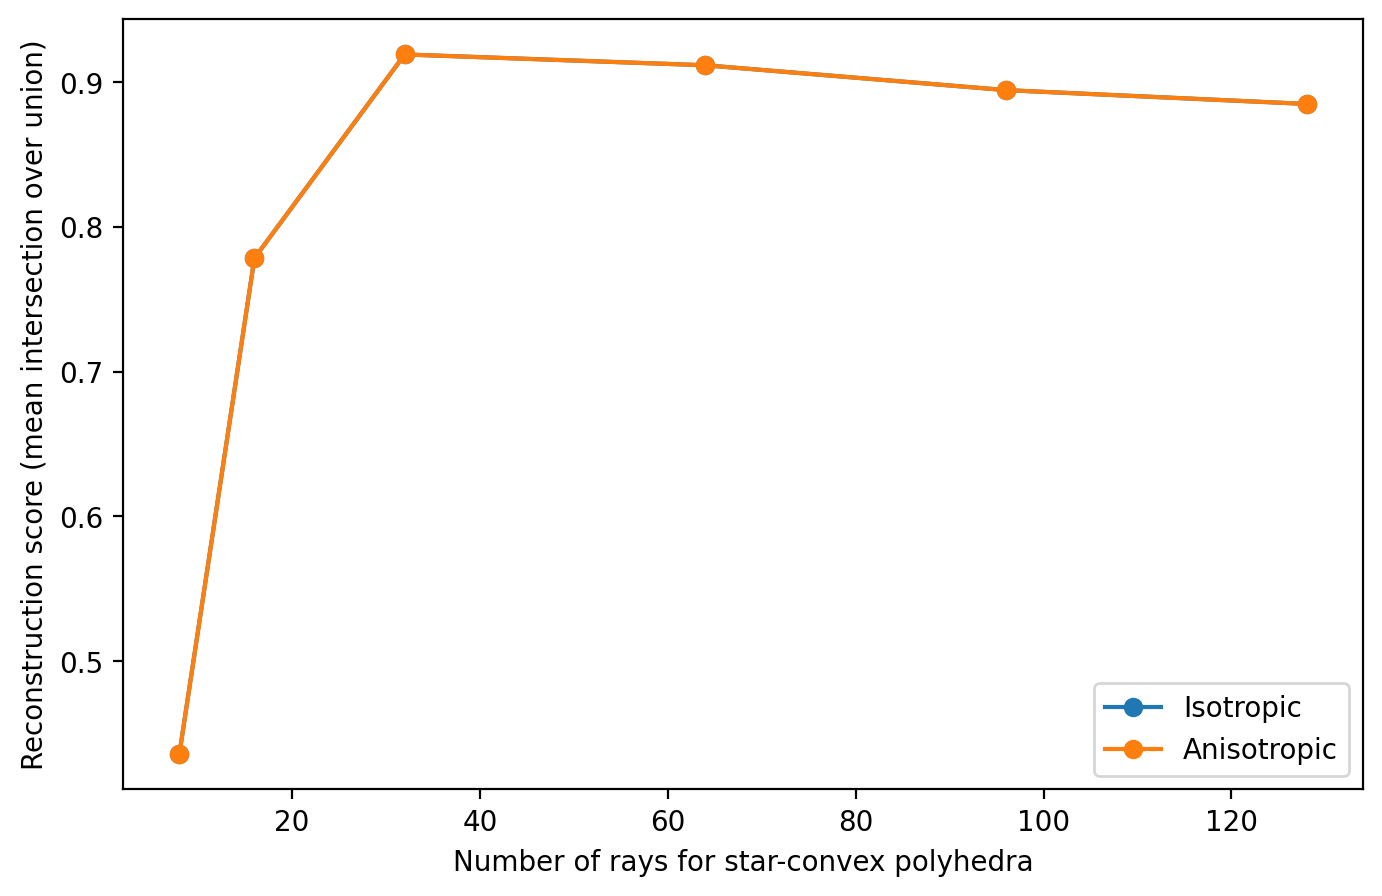

In [16]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores_iso,   'o-', label='Isotropic')
plt.plot(n_rays, scores_aniso, 'o-', label='Anisotropic')
plt.xlabel('Number of rays for star-convex polyhedra')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.legend()
None;

# Example image reconstructed with various number of rays

## Without taking anisotropy into account

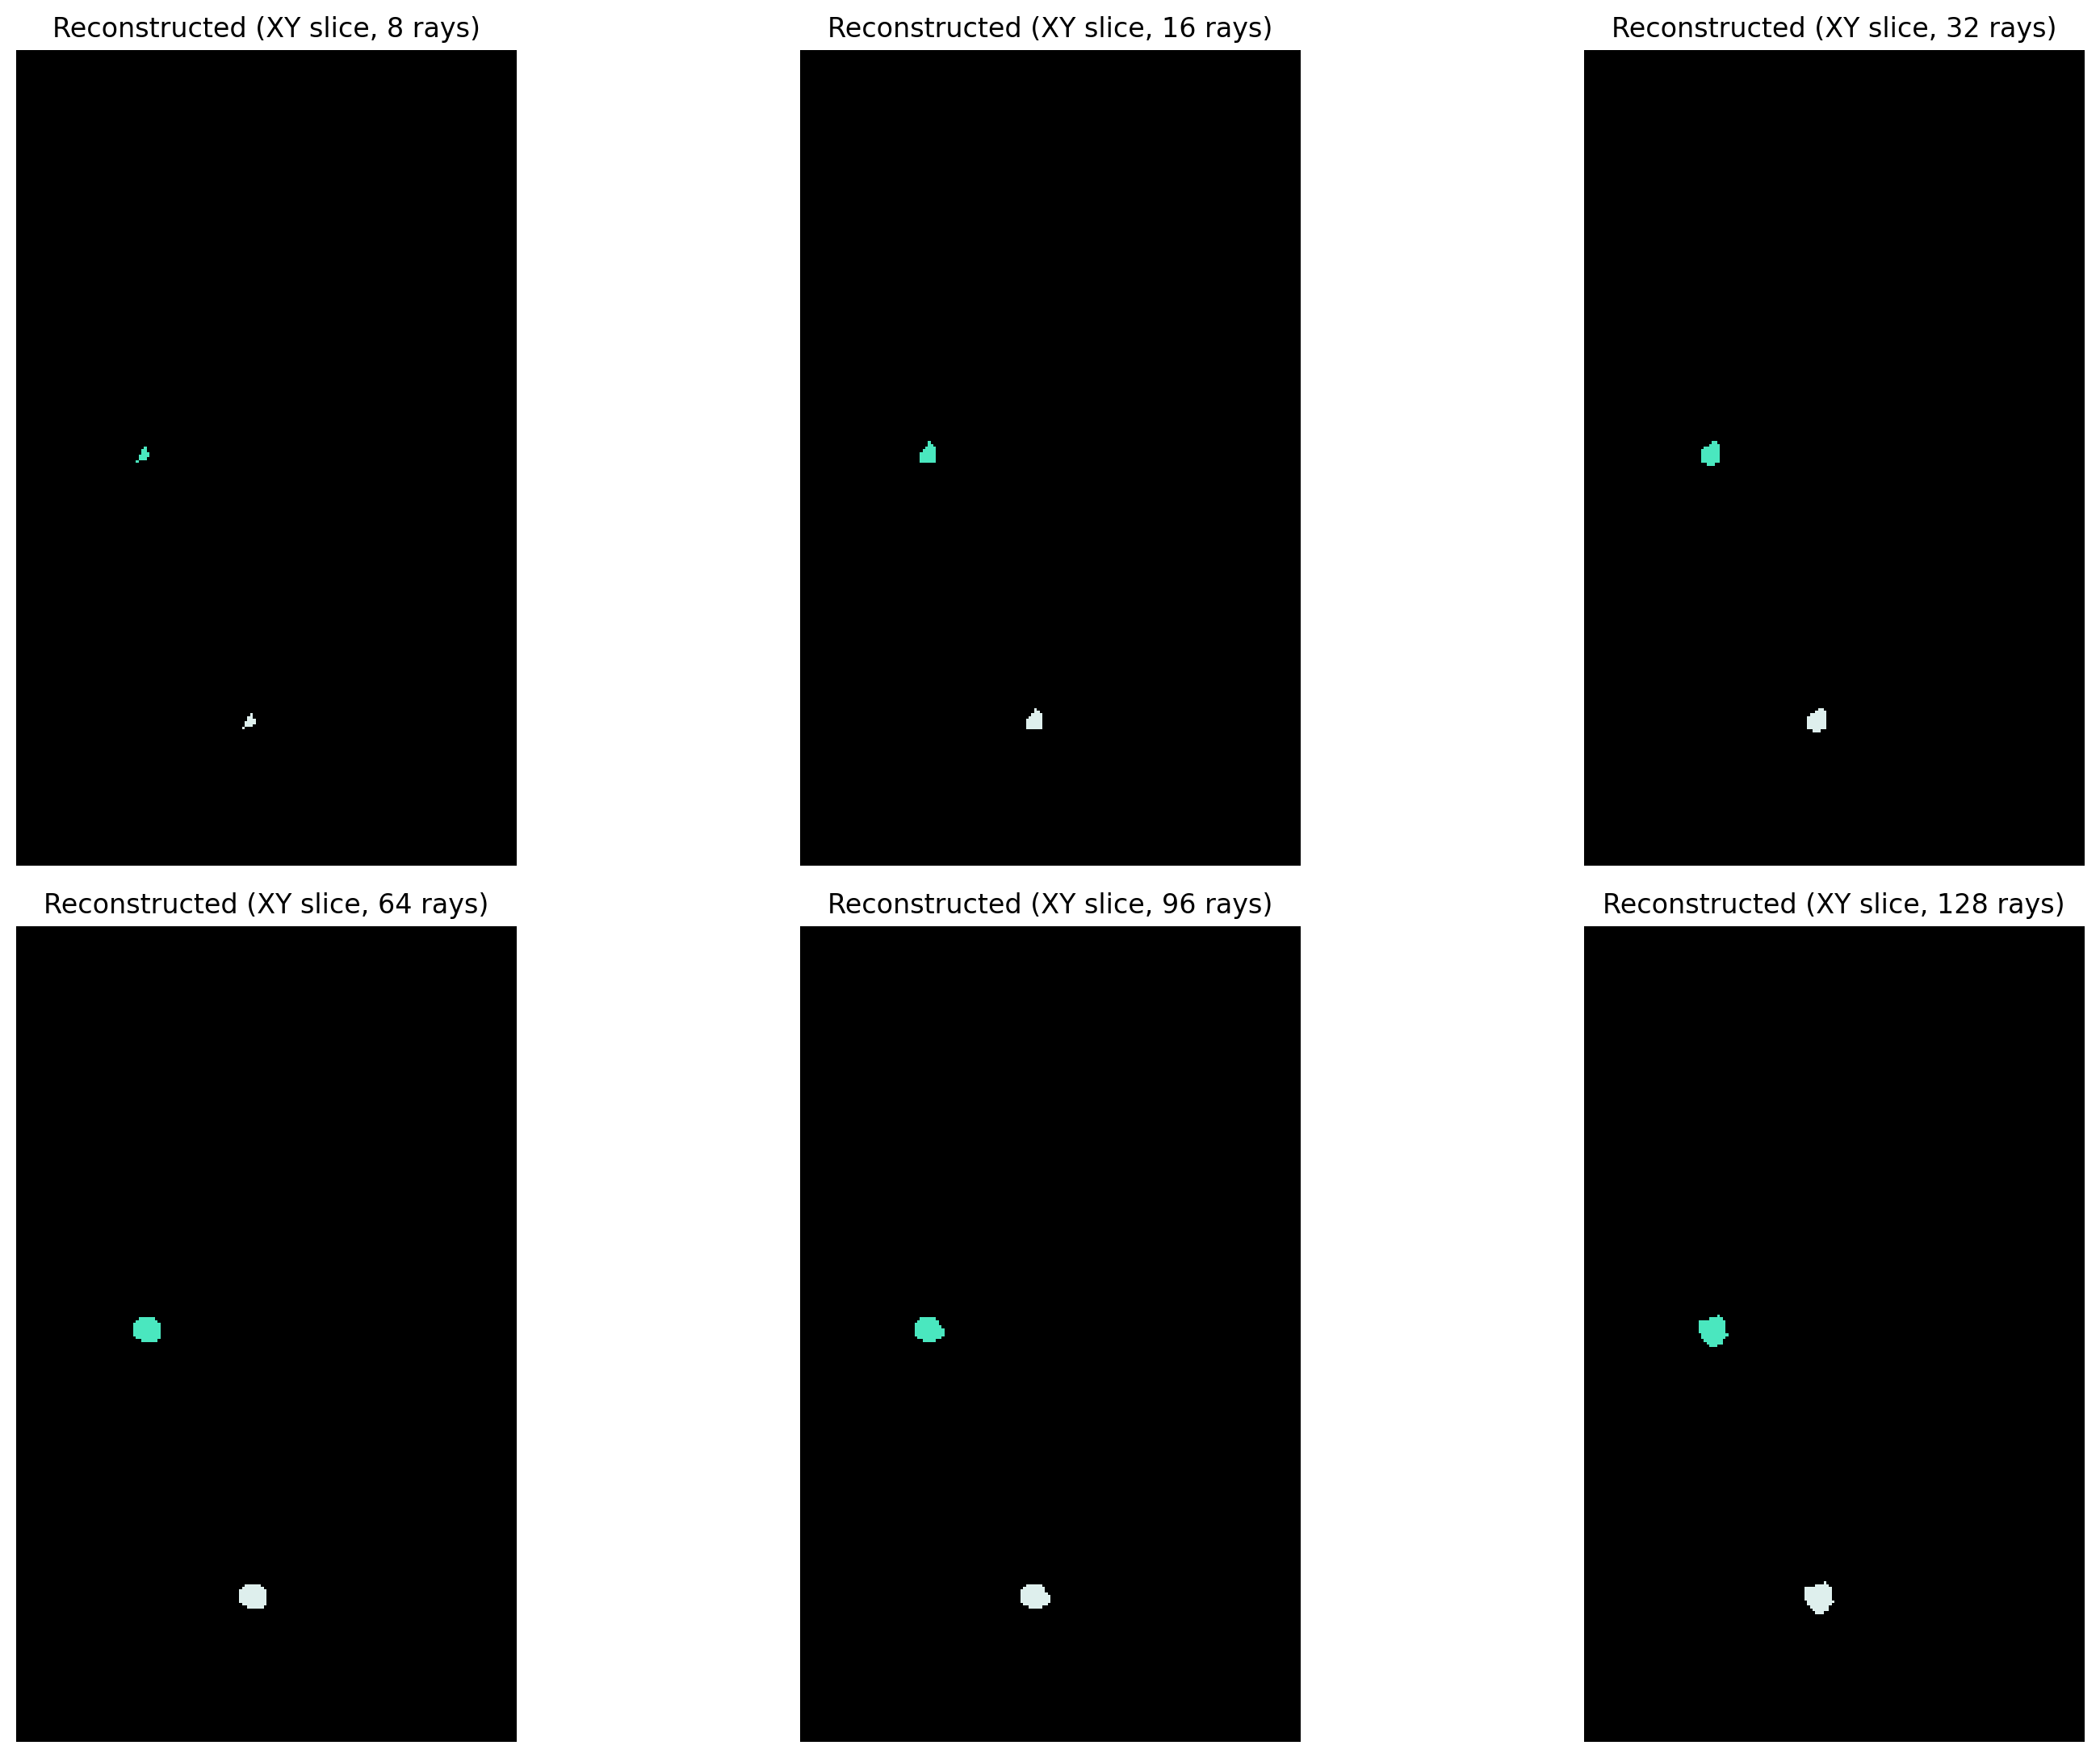

In [17]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    z = lbl.shape[0] // 2
    rays = Rays_GoldenSpiral(r, anisotropy=None)
    a.imshow(relabel_image_stardist3D(lbl, rays)[z], cmap=lbl_cmap)
    a.set_title('Reconstructed (XY slice, %d rays)' % r)
    a.axis('off')
plt.tight_layout();

## Taking anisotropy into account

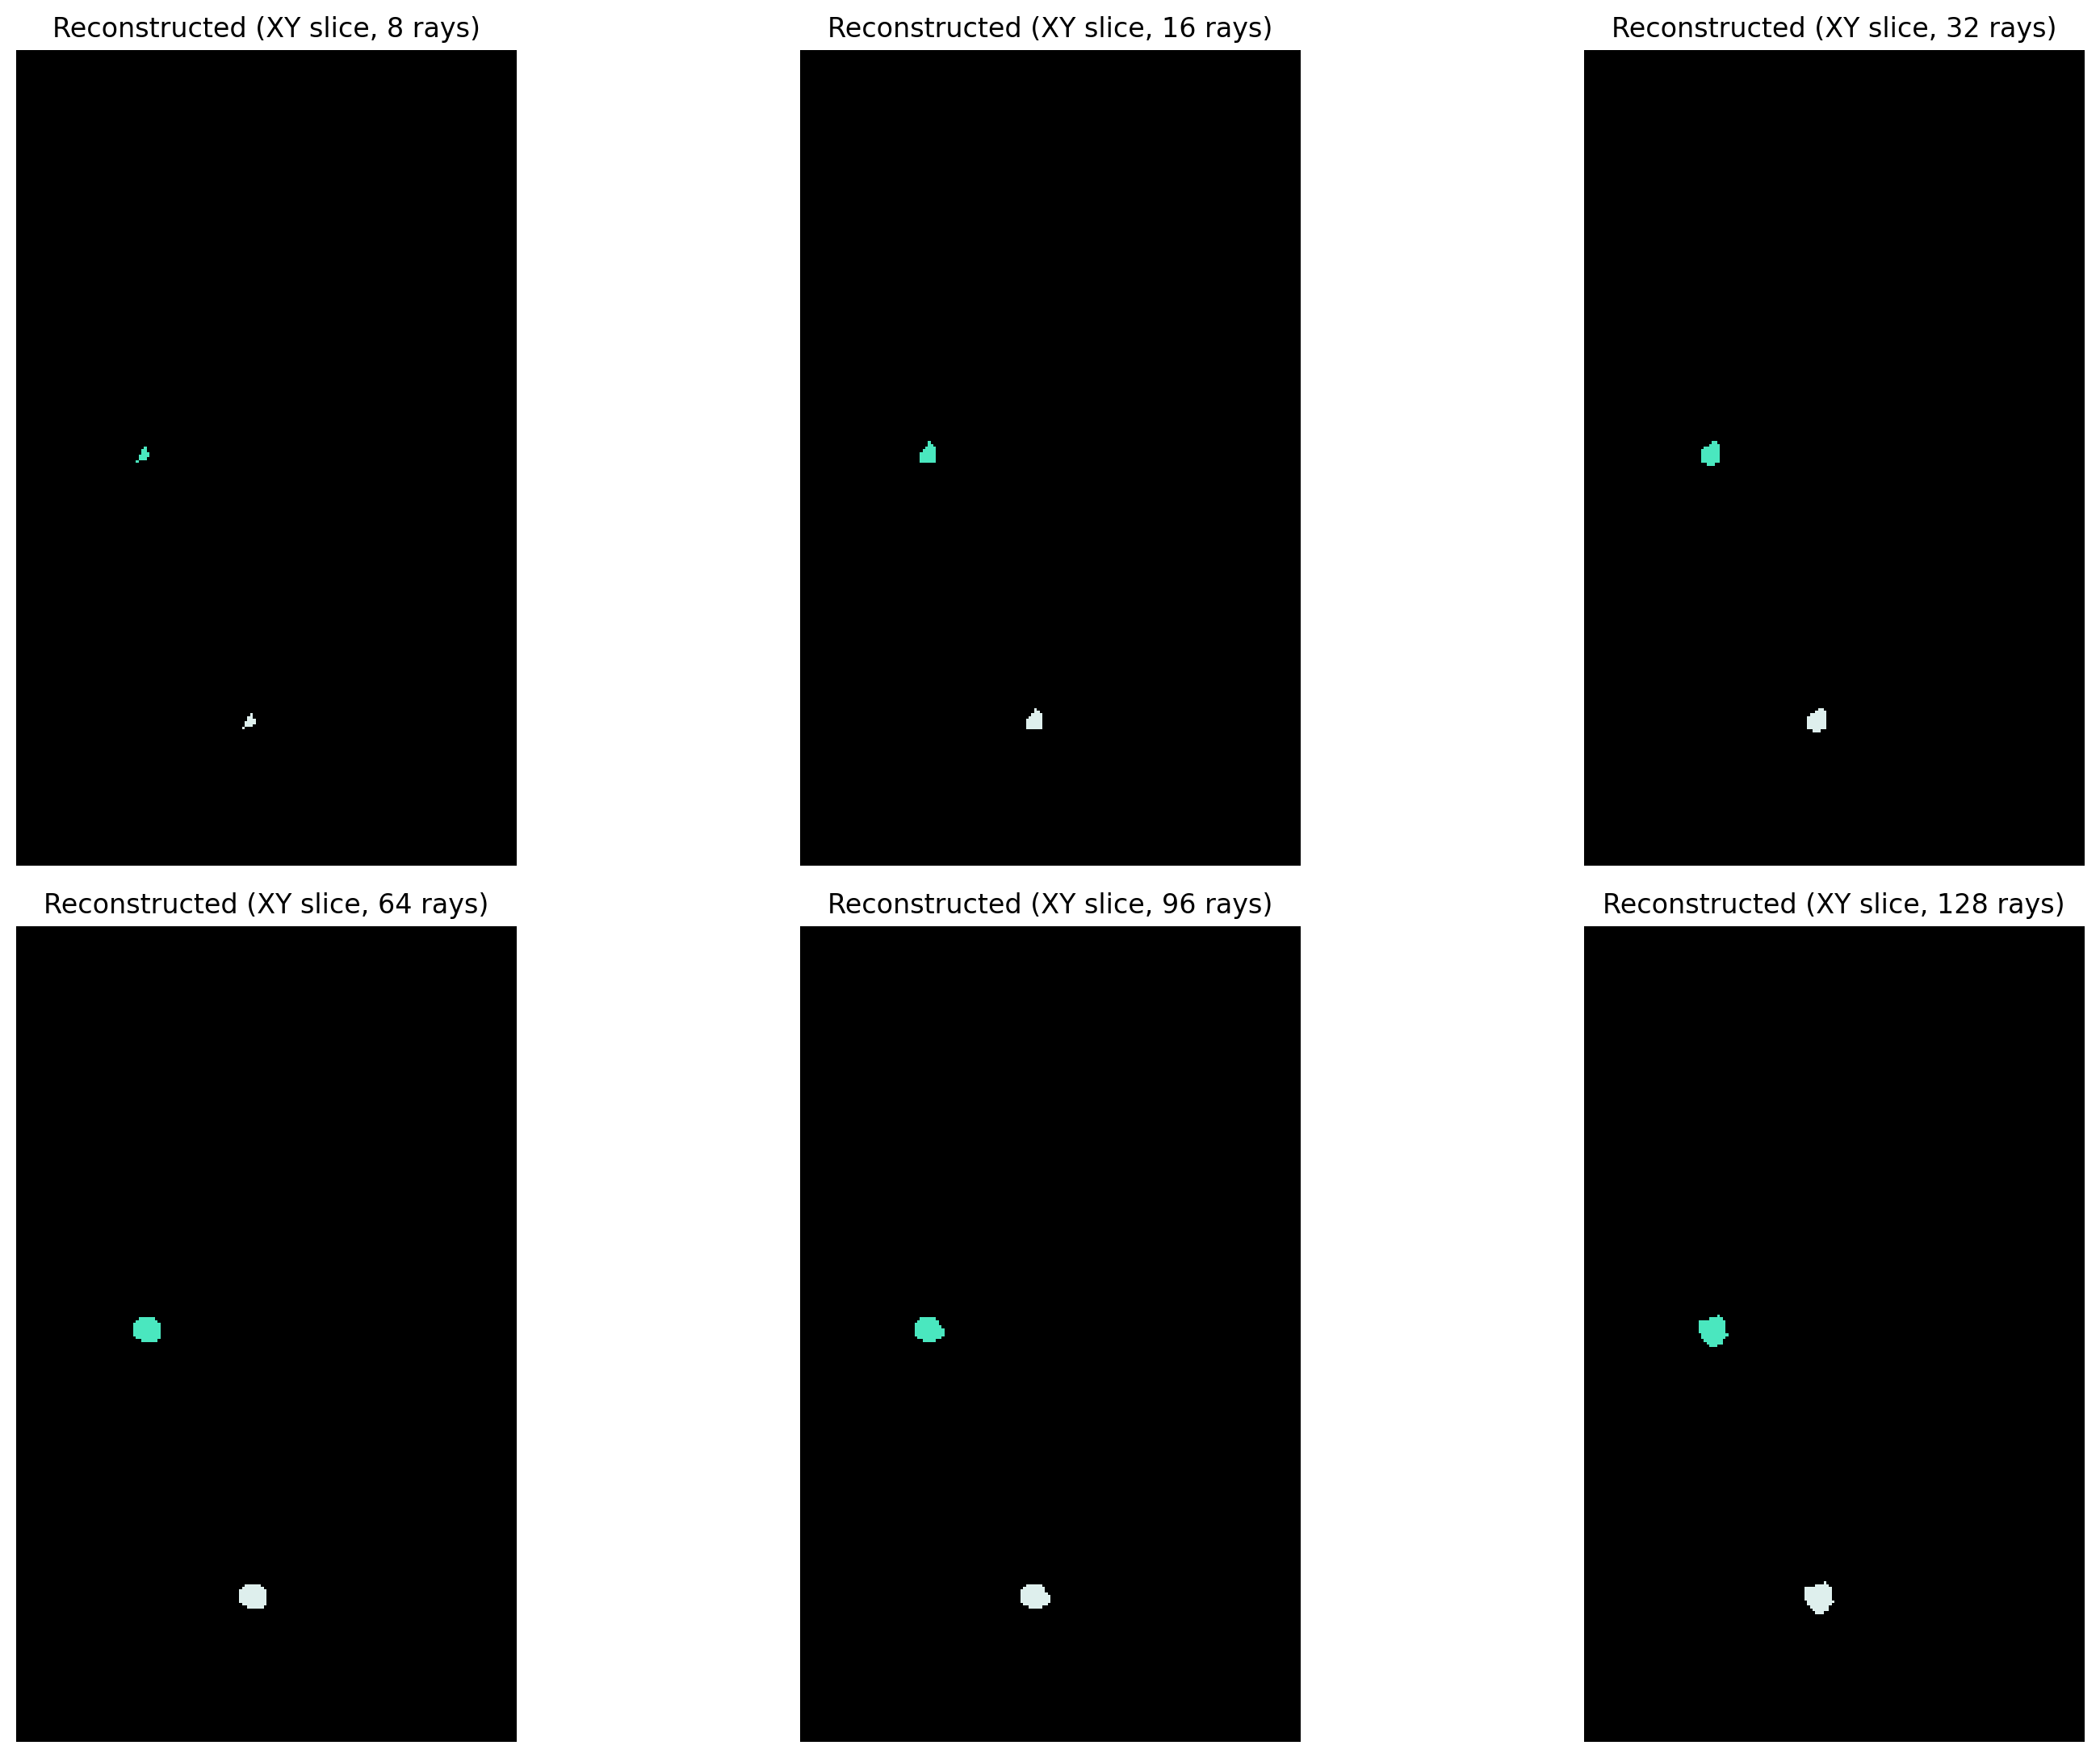

In [18]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    z = lbl.shape[0] // 2
    rays = Rays_GoldenSpiral(r, anisotropy=anisotropy)
    a.imshow(relabel_image_stardist3D(lbl, rays)[z], cmap=lbl_cmap)
    a.set_title('Reconstructed (XY slice, %d rays)' % r)
    a.axis('off')
plt.tight_layout();